In [57]:
# packages to import: xmitgcm, matplotlib, numpy, os, sys, ecco_v4_py, pandas, warnings, pyTMD (remember to install it!), datetime, xarray
# EXPLANATION OF ALL THIS FILE CAN BE FOUND IN TIDAL_ANALYSIS: here we have applied the method developed there to different points listed below
# - English sea point --> tile = 2, i = 31, j = 49
# - New Zeland sea point --> tile = 8, i = 62, j = 38
# - Fundy bay point --> tile = 10, i = 20, j = 58
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import xarray as xr
import pyTMD.crs
import pyTMD.io
import pyTMD.tools
from pyTMD.solve import constants
import pyTMD

In [19]:
data_dir ='/efs_ecco/hvanderz/export_tides'
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run'
ds = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") 

ds = ds.rename({'face':'tile'})

In [20]:
ds['time'] = xr.cftime_range(start='1992-01-01T13:00:00', periods=ds.dims['time'], freq='h')

In [21]:
ds = ds.unify_chunks()

In [22]:
ds_clm = ds.groupby('time.month').mean('time')
ds_anom = ds.groupby('time.month') - ds_clm

In [24]:
n_files = len(ds_anom.time)             
start_time = '1992-01-01 13:00:00'    
freq = 'h'                  
time_eta = pd.date_range(start=start_time, periods=n_files, freq=freq)

In [25]:
epoch = datetime(1992, 1, 1, 0, 0, 0) 
t = np.array([(ti.to_pydatetime() - epoch).total_seconds() / 86400.0 for ti in time_eta])

In [27]:
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']

In [30]:
model_list = sorted(pyTMD.io.model.ocean_elevation())
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'TPXO9.1'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.compress
])
#our directory is /efs_ecco/hvanderz/TMD

In [31]:
start_time_tpxo = '1992-01-01 00:00:00'     
time_eta_tpxo = pd.date_range(start=start_time_tpxo, periods=n_files, freq=freq)

In [32]:
epoch_tpxo = datetime(1992, 1, 1, 0, 0, 0)
t_tpxo = np.array([(ti.to_pydatetime() - epoch_tpxo).total_seconds() / 86400.0 for ti in time_eta_tpxo])

In [33]:
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# ENGLISH CHANNEL

In [68]:
ht_mod = ds_anom.isel(tile=2, i=31, j=49).ETAN.values

In [69]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [70]:
lon = ds_anom.isel(tile=2, i=31, j=49).XC.values
lat = ds_anom.isel(tile=2, i=31, j=49).YC.values
print(lat, lon)

In [71]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

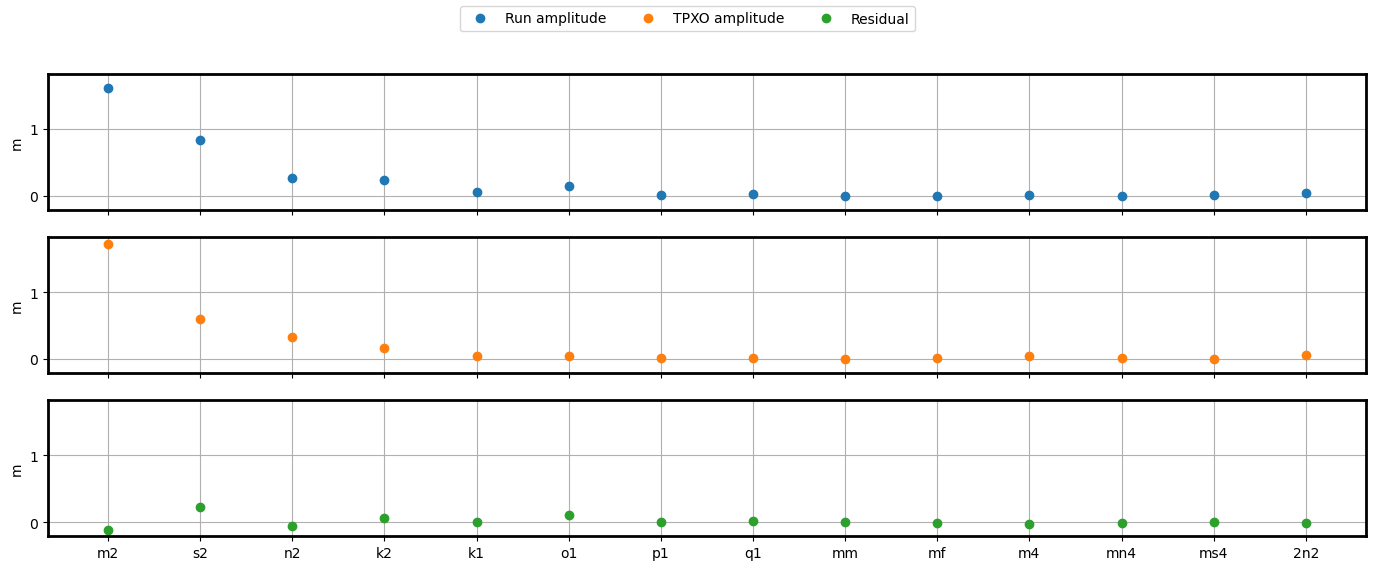

In [72]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

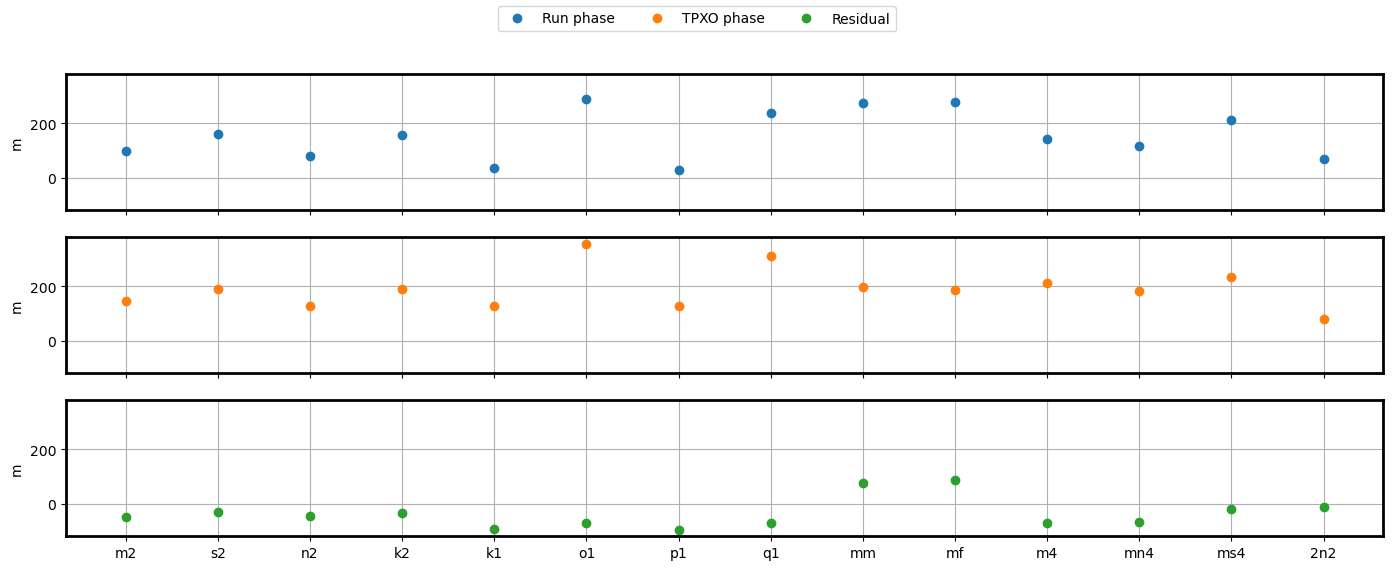

In [73]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# NEW ZELAND

In [74]:
ht_mod = ds_anom.isel(tile=8, i=62, j=38).ETAN.values

In [75]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [77]:
lon = ds_anom.isel(tile=8, i=62, j=38).XC.values
lat = ds_anom.isel(tile=8, i=62, j=38).YC.values
print(lat, lon)

-39.159897 -179.5


In [78]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

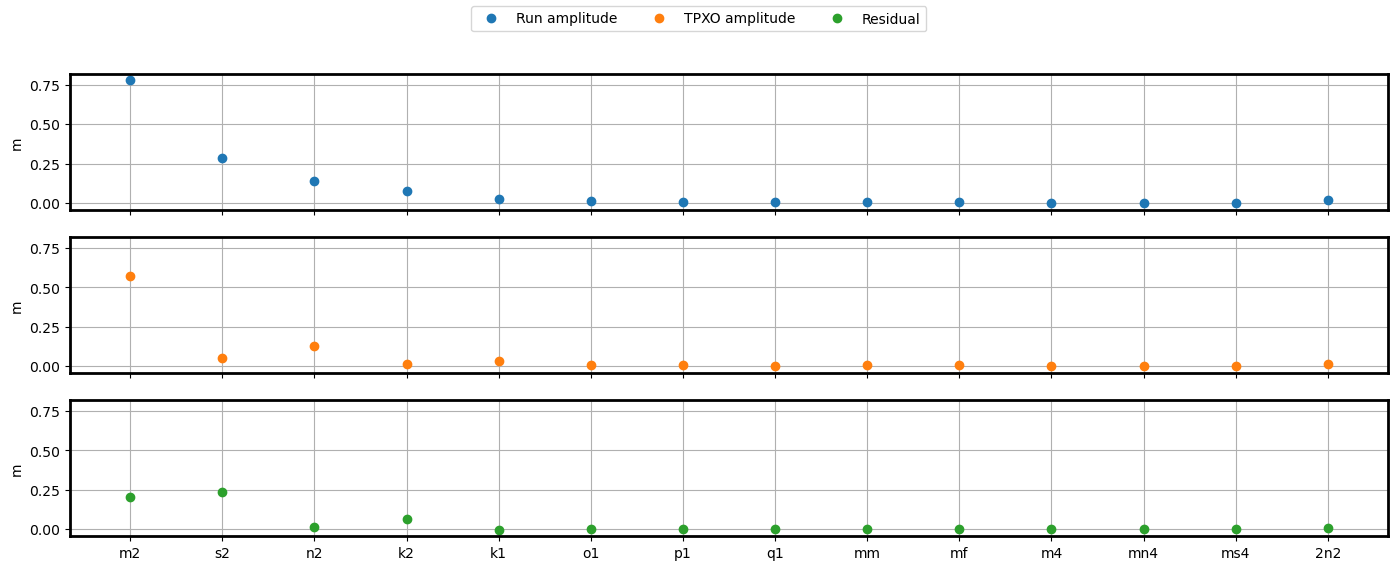

In [79]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

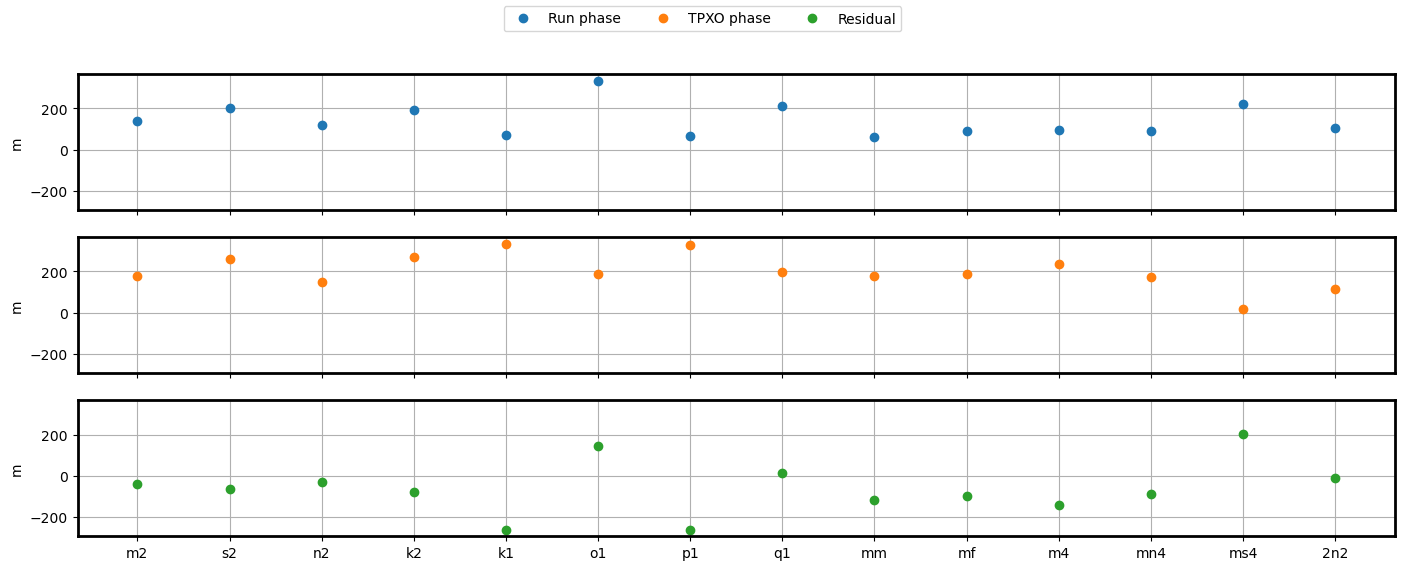

In [80]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# FUNDY BAY

In [81]:
ht_mod = ds_anom.isel(tile=10, i=20, j=58).ETAN.values

In [82]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [84]:
lon = ds_anom.isel(tile=10, i=20, j=58).XC.values
lat = ds_anom.isel(tile=10, i=20, j=58).YC.values
print(lat, lon)

62.14221 -69.254715


In [85]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

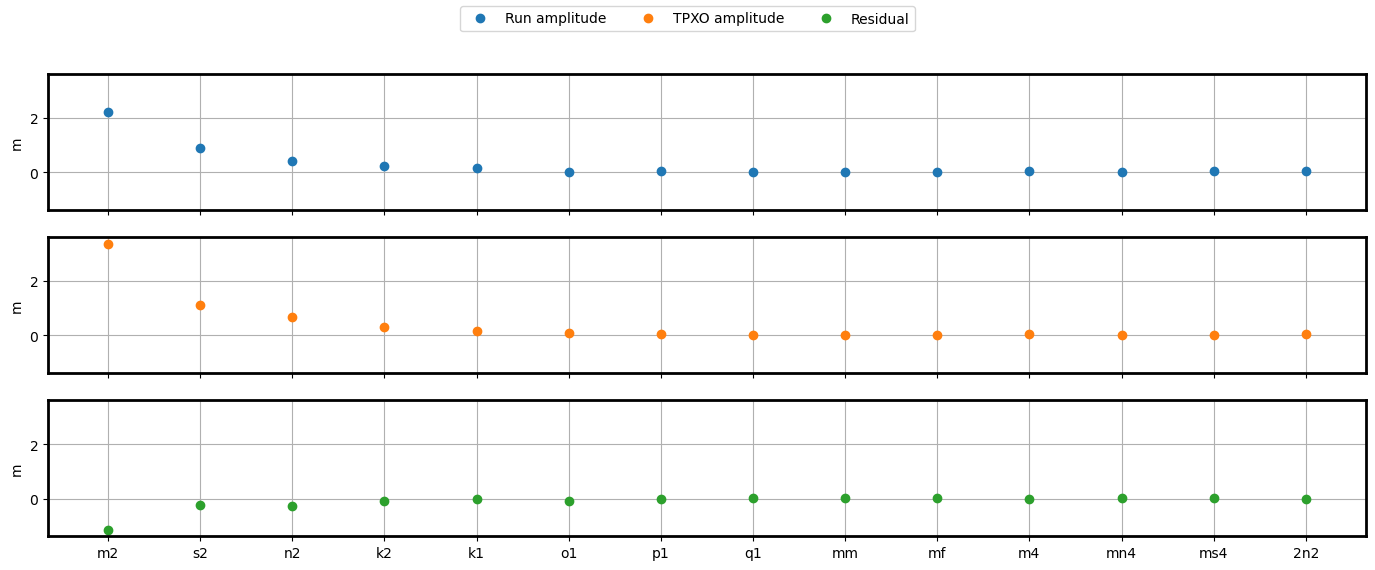

In [86]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

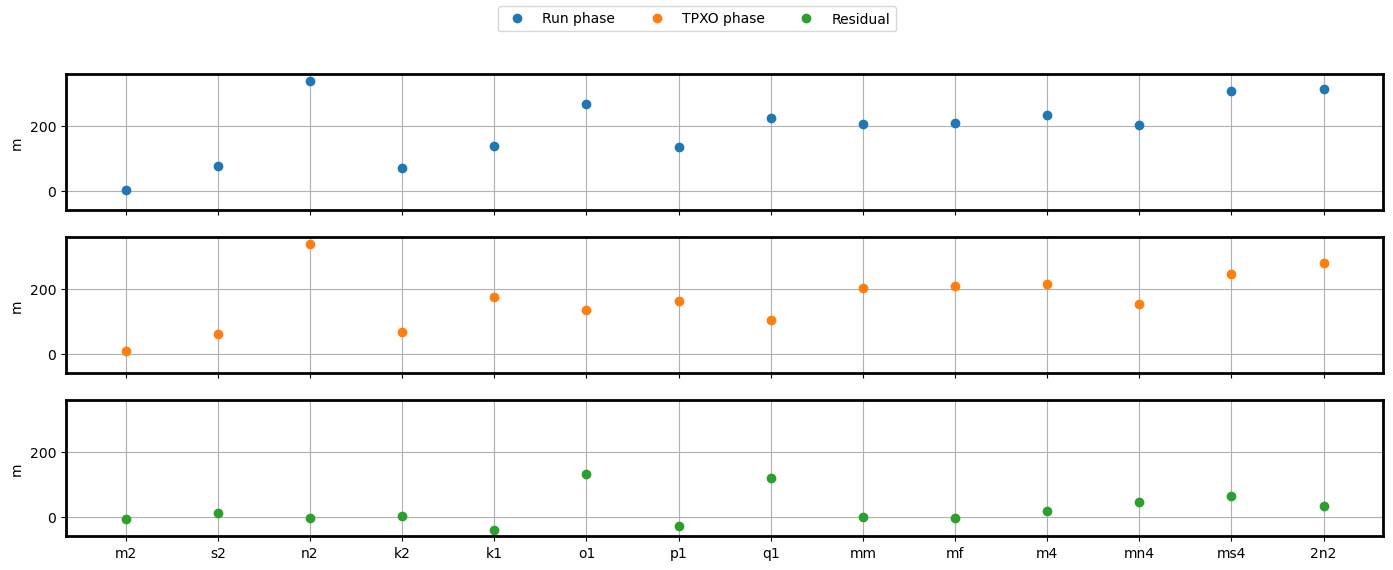

In [87]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()